<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03%20Machine%20Learning/notebooks/07-Decision-Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Árboles de decisión

<img src="https://github.com/DCDPUAEM/DCDP/raw/main/03%20Machine%20Learning/img/DT.png">

En esta notebook usaremos el clasificador [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) de scikit-learn.

Primero, observaremos algunas caracteristicas generales del método y después, lo usaremos en un problema de clasificación con un dataset clásico del machine learning.

🎯 Los objetivos de esta notebook son:

1. Familiarizarse con el uso del algoritmo y sus hiperparámetros principales.
2. Percibir las particularidades de este algoritmo y compararlo con otros algoritmos.
3. Usar el algoritmo en un dataset real.  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#@title Función para graficar la frontera de decisión

from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np

def graficar_FD(X,y,clf,h=0):
    '''
    X es todas las instancias las cuales incluiremos en el gráfico
    '''
    assert X.shape[1] == 2   # Sólo funciona para datos en dimensión 2
    feature_1, feature_2 = np.meshgrid(
    np.linspace(X[:,0].min()-h, X[:, 0].max()+h),
    np.linspace(X[:, 1].min()-h, X[:, 1].max()+h)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_grid_pred = clf.predict(grid)
    y_grid_pred = y_grid_pred.reshape(feature_1.shape)
    display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_grid_pred
    )
    display.plot()
    display.ax_.scatter(
        X[:, 0], X[:, 1], c=y, edgecolor="black"
    )
    plt.show()
    return display.ax_

El módulo `dtreeviz` es útil para la visualización de árboles de decisión y la interpretación de modelos ([documentación](https://github.com/parrt/dtreeviz)).

In [ ]:
!pip install -qq dtreeviz

# Ejemplo 1: Un ejemplo ilustrativo

Con este ejemplo, exploraremos el uso básico del álgoritmo y observaremos las características y particularidades del clasificador DT.

## 1. Datos linealmente separables con una línea horizontal



### Conjunto de datos

En este primer ejemplo generamos un conjunto de datos linealmente separables con `make_blobs`. Estos datos pueden ser separados con una línea vértical, es decir con una condición de tipo

* Si $x>\alpha$ entonces $(x,y)\in\text{clase}_0$.
* Si $x<\alpha$ entonces $(x,y)\in\text{clase}_1$.

Primero, generamos y visualizamos los datos

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=600,centers=2,random_state=31)

# colors = {0: 'blue', 1: 'red'} # Forzar a que cada clase tenga un color determinado
colors = ['blue' if yi==0 else 'red' for yi in y] # Forzar a que cada clase tenga un color determinado

plt.figure()
# plt.scatter(X[:,0],X[:,1],c=[colors[yi] for yi in y])
plt.scatter(X[:,0],X[:,1],c=colors)
plt.show()

Dividimos los datos en *train/test*. Entrenamos el árbol de decisión usando la implementación de scikit-learn `sklearn.tree.DecisionTreeClassifier`. Realizamos la predicción sobre el conjunto de prueba.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% entrenamiento y 30% prueba

clf = DecisionTreeClassifier()  # Inicializar el modelo con los hiperparámetros por defecto
clf = clf.fit(X_train,y_train)  # Entrenar el modelo
y_pred = clf.predict(X_test)    # Predecir las etiquetas para el conjunto de prueba

### Entrenamiento y evaluación

Como es de esperar, obtenemos el 100% en todas las métricas

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),3)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True)
plt.show()

### Visualización del árbol (opcional)

Veamos el árbol de decisión usando [`export_text`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html) del módulo `tree` de scikit-learn.

In [ ]:
from sklearn.tree import export_text

text_representation = export_text(decision_tree=clf,feature_names=['x','y'])
print(text_representation)

In [ ]:
_ = graficar_FD(X,y,clf,h=0.5)

## Datos linealmente separables con una línea no vertical.

Transformamos los datos para ahora sean separables con línea no horizontal. Para esto, rotamos cada punto un ángulo $\theta=\frac{\pi}{4}=45°$, además, trasladamos la clase *positiva* con el vector $z=(-1,-2)$.

**Ocultamos el código por limpieza**

In [ ]:
#@title Conjunto de datos

import numpy as np

theta = np.pi/4 # Ángulo de rotación
R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]) # Matriz de rotación

Xr = np.transpose(R@np.transpose(X)) # Rotamos el dataset

idxs = np.where(y==1)[0]   # Obtenemos los índices donde y=1

Xr[idxs,:] = Xr[idxs,:] + np.array([-1,-2])

fig, axs = plt.subplots(1,2,figsize=(9,5),sharey=True)
axs[0].scatter(X[:,0],X[:,1],c=['blue' if yi==0 else 'red' for yi in y])
axs[0].set_title("Original dataset")
axs[1].scatter(Xr[:,0],Xr[:,1],c=['blue' if yi==0 else 'red' for yi in y])
axs[1].set_title("Transformed dataset")
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=0.3, random_state=101) # 70% training and 30% test

### Entrenamiento y evaluación

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()  # Create Decision Tree classifier object
clf = clf.fit(X_train,y_train)  # Train Decision Tree Classifier
y_pred = clf.predict(X_test)    # Predict the response for test dataset

Dados que los datos siguen siendo linealmente separables, seguimos obteniendo el 100% en todas las métricas.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),5)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g')
plt.show()

### Visualización del árbol

Sin embargo, el árbol empieza a hacerse más complejo.

In [ ]:
from sklearn.tree import export_text

text_representation = export_text(decision_tree=clf,feature_names=['x','y'])
print(text_representation)

La frontera de decisión no es la que esperaríamos:

In [ ]:
_ = graficar_FD(Xr,y,clf,h=0.5)

Como podemos ver, este clasificador no separa con una línea en general, aún si los datos son linealmente separables. **Los árboles de decisión obtienen una FD compuesta de segmentos de línea verticales y horizontales.**

### Efecto de perturbaciones

Ahora, observemos el efecto de perturbar levemente el conjunto de datos. ¿Qué le pasa al arbol de decisión?

Este tipo de perturbaciones pueden ocurrir como resultado de errores de medición o de la presencia de outliers.

Movemos un par de puntos cerca de la FD.

In [ ]:
Xrp = Xr.copy()
Xrp[192] = Xrp[192] + np.array([-1,-2])
Xrp[486] = Xrp[486] + np.array([2,1])

fig, axs = plt.subplots(1,2,figsize=(9,5),sharey=True)
axs[0].scatter(Xr[:,0],Xr[:,1],c=['blue' if yi==0 else 'red' for yi in y])
axs[0].set_title("Original dataset")
axs[1].scatter(Xrp[:,0],Xrp[:,1],c=['blue' if yi==0 else 'red' for yi in y])
axs[1].set_title("Perturbed dataset")
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(Xrp, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()  # Create Decision Tree classifier object
clf = clf.fit(X_train,y_train)  # Train Decision Tree Classifier
y_pred = clf.predict(X_test)    # Predict the response for test dataset

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),5)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g')
plt.show()

In [ ]:
from sklearn.tree import export_text

text_representation = export_text(decision_tree=clf,feature_names=['x','y'])
print(text_representation)

In [ ]:
_ = graficar_FD(Xrp,y,clf,h=0.5)

# Ejemplo 2: MNIST

Ver la diferencia entre normalizar o no

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()

X = digits.data
y = digits.target

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [3]:
print(f"Accuracy entrenamiento: {clf.score(X_train,y_train)}")
print(f"Accuracy prueba: {clf.score(X_test,y_test)}")

Accuracy entrenamiento: 1.0
Accuracy prueba: 0.8574074074074074


Viendo las métricas, ¿hay señales de entrenamiento?

Accuracy: 0.857
Recall: 0.86
Precision: 0.858


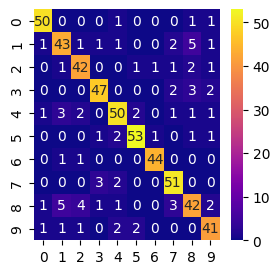

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred, average='macro'),3)}")
print(f"Precision: {round(precision_score(y_test,y_pred, average='macro'),3)}")

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g')
plt.show()

In [5]:
from sklearn import tree

from sklearn.tree import export_text

text_representation = export_text(decision_tree=clf,feature_names=[f'pixel_{j+1}' for j in range(X.shape[1])])
print(text_representation)

|--- pixel_37 <= 0.50
|   |--- pixel_34 <= 0.50
|   |   |--- pixel_22 <= 6.00
|   |   |   |--- pixel_5 <= 11.50
|   |   |   |   |--- pixel_60 <= 11.00
|   |   |   |   |   |--- class: 6
|   |   |   |   |--- pixel_60 >  11.00
|   |   |   |   |   |--- class: 2
|   |   |   |--- pixel_5 >  11.50
|   |   |   |   |--- class: 5
|   |   |--- pixel_22 >  6.00
|   |   |   |--- pixel_44 <= 7.00
|   |   |   |   |--- class: 9
|   |   |   |--- pixel_44 >  7.00
|   |   |   |   |--- pixel_11 <= 9.00
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- pixel_11 >  9.00
|   |   |   |   |   |--- class: 8
|   |--- pixel_34 >  0.50
|   |   |--- pixel_7 <= 1.50
|   |   |   |--- pixel_14 <= 1.50
|   |   |   |   |--- pixel_4 <= 7.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- pixel_4 >  7.50
|   |   |   |   |   |--- class: 6
|   |   |   |--- pixel_14 >  1.50
|   |   |   |   |--- pixel_29 <= 4.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- pixel_29 >  4.50
|   |   |   |   |   |--- pixel_

### No es necesaria la normalización

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# ----- Normalizando ----
pl = Pipeline([('scl',MinMaxScaler()),
               ('clf',DecisionTreeClassifier())])
pl.fit(X_train,y_train)
print(f"Accuracy de prueba (Normalizando): {pl.score(X_test,y_test)}")

# ---- Sin normalizar ----
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
print(f"Accuracy de prueba (Sin normalizar): {clf.score(X_test,y_test)}")


Accuracy de prueba (Normalizando): 0.8277777777777777
Accuracy de prueba (Sin normalizar): 0.8574074074074074


### Efecto de los hiperparámetros

Veamos cuál es el efecto en el accuracy de cambiar el parámetro `max_depth`

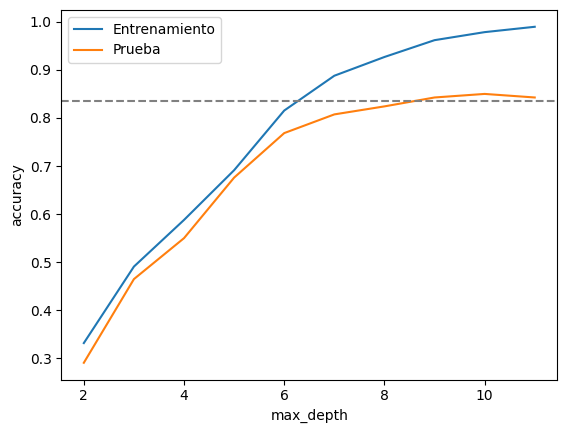

In [12]:
depths = [2,3,4,5,6,7,8,9,10,11]
train_scores = []
test_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    train_scores.append(clf.score(X_train,y_train))
    test_scores.append(clf.score(X_test,y_test))

plt.figure()
plt.plot(depths,train_scores,label='Entrenamiento')
plt.plot(depths,test_scores,label='Prueba')
plt.axhline(0.835,color='gray',linestyle='--')
plt.legend(loc='best')
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

Con la ayuda de gridsearch, veamos cuál es la mejor profundidad que podemos obtener

In [16]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator = DecisionTreeClassifier(),
                  param_grid = {'max_depth': depths})
gs.fit(X_train,y_train)
print(gs.best_params_)
print(f"Accuracy de prueba con el mejor clasificador: {gs.best_estimator_.score(X_test,y_test)}")

{'max_depth': 9}
Accuracy de prueba con el mejor clasificador: 0.8407407407407408


### Comparación con otros algoritmos

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

dt_times = []
for j in range(5):
    start = time.time()
    clf = DecisionTreeClassifier(max_depth=None)
    clf = clf.fit(X_train,y_train)
    end = time.time()
    dt_times.append(end-start)
print(f"Tiempo promedio de ejecución DT: {np.mean(dt_times)}")

svm_times = []
for j in range(5):
    start = time.time()
    clf = SVC(kernel='linear')
    clf = clf.fit(X_train,y_train)
    end = time.time()
    svm_times.append(end-start)
print(f"Tiempo promedio de ejecución SVM: {np.mean(svm_times)}")


¿Cómo se compara el rendimiento?

In [ ]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

clf = SVC()
clf = clf.fit(X_train,y_train)
print(f"Accuracy de prueba (SVM): {clf.score(X_test,y_test)}")

print(f"Accuracy de prueba (DT): {gs.best_estimator_.score(X_test,y_test)}")

# Ejemplo 3: PIMA Dataset

## 1. El conjunto de datos

Este dataset fue creado por el *National Institute of Diabetes and Digestive and Kidney Diseases* de Estados Unidos. El objetivo del dataset es predecir el diagnostico de cuándo un paciente tiene diabetes o no, basado en ciertas mediciones incluidas en el dataset. Varias restricciones fueron usadas en la selección de estas instancias para filtrar el dataset. En particular, se trata pacientes femeninas de al menos 21 años de edad pertenecientes al grupo indígena Pima de Arizona.

Las variables incluidas son el numero de embarazos la paciente ha tenido, su BMI, nivel de insulina, edad, entre otras.

El dataset se encuentra en https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.

In [ ]:
import pandas as pd

url = 'https://github.com/DCDPUAEM/DCDP/raw/main/03%20Machine%20Learning/data/diabetes.csv'
df = pd.read_csv(url,index_col=0)
df

## Entrenar el clasificador y resultados

Escogemos las *features* que usaremos y definimos el dataset de features y el vector de etiquetas

In [ ]:
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']

X = df[feature_cols].values    # Features
y = df['label'].values         # Target variable

Dividimos los datos en train/test. Entrenamos el árbol de decisión usando la implementación de scikit-learn sklearn.tree.DecisionTreeClassifier. Realizamos la predicción sobre el conjunto de prueba.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),5)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")

target_labels = ['no diabetes','diabetes']

plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

## Importancia de las features

Podemos obtener la importancia de las features

In [ ]:
clf.feature_importances_

In [ ]:
importances_df = pd.DataFrame({'feature':feature_cols,'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
importances_df

## Visualizaciones de los árboles

Al visualizar árboles de decisión recuerda que el escalamiento no es necesario, en general. Si decides escalar, esto tiene repercusiones en la visualización del árbol.

### Con scikit-learn

In [ ]:
from sklearn.tree import export_text

text_representation = export_text(decision_tree=clf,
                                       feature_names=feature_cols)
print(text_representation)

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))   # Definimos una figura más grande para que quepa
_ = plot_tree(clf, feature_names=feature_cols,
                   class_names=['0','1'],
                   filled=True)

### Using [graphviz](https://graphviz.org/)

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('diabetes.png')
Image(graph.create_png())

### Using [dtreeviz](https://github.com/parrt/dtreeviz)

In [ ]:
from dtreeviz import model

ct = model(clf, X, y, feature_names = feature_cols)
ct.view(fontname='DejaVu Sans')

Si queremos salvar la imagen

In [ ]:
v = ct.view(fontname='DejaVu Sans')
v.save("tree.svg")

#⭕ **Práctica**:

¿Puedes subir las métricas de desempeño de este clasificador en este dataset? A continuación hay algunas opciones que puedes probar:

* Observar la variable 'bmi', tiene valores 0, ¿qué sentido tienen estos?
    * Puedes quitar esas instancias.
    * Puedes quitar la variable.
* Cambiar el conjunto de features, ya sea manualmente o con algún método como [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold), [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html), etc.
* Realizar un gridsearch en los parámetros del clasificador: `max_depth`, `criterion`, `min_samples_leaf`.

A continuación se muestra una estrategia para obtener alrededor de 75% de accuracy.

Esta estrategia usa un imputador para reemplazar los valores 0 con el promedio. Además, se hace selección de features. Todo se junta en un pipeline.

**Además, realizamos un gridsearch en un pipeline.**

Puedes probar modificando algunos pasos para buscar obtener un mejor rendimiento.

In [18]:
import pandas as pd

url = 'https://github.com/DCDPUAEM/DCDP/raw/main/03%20Machine%20Learning/data/diabetes.csv'
df = pd.read_csv(url,index_col=0)
df

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [19]:
feature_names = df.columns.to_list()[:-1]

print(f"Nombres de las features: {feature_names}")

Nombres de las features: ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']


In [20]:
X = df.loc[:,feature_names].values
y = df['label'].values

### ⚡ GridSearch con pipeline

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "selector__threshold": [0,0.1,0.2,0.5],
    "clasificador__criterion": ['gini','entropy'],
    "clasificador__max_depth": [None,10],
    "clasificador__min_samples_split": [2,3,4]
}

search = GridSearchCV(pl, param_grid, n_jobs=2)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

best_clf = search.best_estimator_

print(f"Accuracy en el entrenamiento: {best_clf.score(X_train,y_train)}")
print(f"Accuracy en la prueba: {best_clf.score(X_test,y_test)}")

ValueError: Invalid parameter 'clasificador' for estimator Pipeline(steps=[('scl', MinMaxScaler()), ('clf', DecisionTreeClassifier())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
y_pred = best_clf.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),3)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")